In [50]:
import copy

from desdeo_emo.population import SurrogatePopulation, create_new_individuals
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.utilities import hypervolume_indicator

from imodels import C45TreeClassifier

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from sklearn import tree

# Init problem, population, and selectin operator

In [51]:
n_problem_variables = 5
n_problem_objectives = 3
problem = test_problem_builder("DTLZ2", n_problem_variables, n_problem_objectives)

# population
pop_size = 50
initial_population = create_new_individuals("RandomDesign", problem, pop_size=pop_size)
xover_op = SBX_xover()
mutation_op = BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds())

population = SurrogatePopulation(problem, pop_size, initial_population, xover_op, mutation_op, None)

# selection
tournament_size = 2
selection_op = TournamentSelection(None, tournament_size=tournament_size)

# Define fitness operator

In [52]:
def naive_sum(population):
    objective_values = population.problem.evaluate(population.individuals).objectives
    return np.atleast_2d(np.sum(objective_values, axis=1)).T

def dist_to_ideal(population, ideal=np.zeros(n_problem_objectives)):
    objective_values = population.problem.evaluate(population.individuals).objectives
    return np.atleast_2d(np.linalg.norm(objective_values - ideal, axis=1)).T

def must_sum_to_one(population):
    objective_values = population.problem.evaluate(population.individuals).objectives
    sums = np.sum(objective_values**2, axis=1)
    return np.atleast_2d(abs(sums - 1)).T

def single_objective(population, obj_index = 0):
    objective_values = population.problem.evaluate(population.individuals).objectives
    return np.atleast_2d(objective_values[:, obj_index]).T

# Define machine learning step

In [53]:
def machine_learning_mode(population, fitness_fun):
    # sort the individuals according to the fitness function
    fitness_values = fitness_fun(population)
    sorted_indices = np.squeeze(np.argsort(fitness_values, axis=0))
    
    h_split = 0.2
    l_split = 0.2
    
    h_split_ind = int(h_split*len(sorted_indices))
    l_split_ind = int(l_split*len(sorted_indices))
    
    #print(f"H split index: {h_split_ind}")
    #print(f"L split index: {l_split_ind}")
    
    # divide into H and L groups
    h_group_indices = sorted_indices[0:h_split_ind]
    l_group_indices = sorted_indices[-l_split_ind:]
    
    #print(f"H group indices: {h_group_indices}")
    #print(f"L group indices: {l_group_indices}")
    
    h_sample = population.individuals[h_group_indices]
    l_sample = population.individuals[l_group_indices]
    
    Y = np.hstack((np.ones(len(h_sample)), -np.ones(len(l_sample))))
    X = np.vstack((h_sample, l_sample))
    
    # print(f"Y: {Y}")
    # print(f"X: {X}")
    # print(f"len(X): {len(X)}")
    
    # classifier = tree.DecisionTreeClassifier(criterion="gini")
    classifier = C45TreeClassifier()
    print("Fitting tree...")
    classifier = classifier.fit(X, Y)
    # tree.plot_tree(classifier, class_names=["H", "L"])
    # plt.show()
    # tree.plot_tree(classifier, class_names=["H", "L"], filled=True)
    
    # Generate new fit individuals
    n_individuals_needed = len(sorted_indices) - len(h_group_indices)
    n_found = 0
    
    lower_bounds = population.problem.get_variable_lower_bounds()
    upper_bounds = population.problem.get_variable_upper_bounds()
    
    ranges = upper_bounds - lower_bounds
    
    new_individuals = []
    
    print("Finding new individuals...")
    while n_found < n_individuals_needed:
        # randomly generate new individuals until n_individuals_needed new individuals with a class of 1 are found.
        candidate = np.random.rand(len(ranges)) * ranges + lower_bounds
        
        if classifier.predict(np.atleast_2d(candidate))[0] == 1:
            # Good candidate
            new_individuals.append(candidate)
            n_found += 1
            
    # add new fit candidates to existing H group
    final_individuals = np.vstack((h_sample, np.array(new_individuals)))
    
    return final_individuals


# Evolve

In [55]:
n_generations = 10
past_generations = []
use_ml = True
use_darwin = True

past_generations.append(copy.copy(population))
fitness_op = dist_to_ideal
ml_op = dist_to_ideal

n_total_iterations = 5


for _ in range(n_total_iterations-1):
    if use_darwin:
        print("Darwin")
        # darwinian mode
        for _ in range(n_generations):
            # select individuals to mate
            fitnesses = fitness_op(population)
            to_mate = selection_op.do(population, fitnesses)

            # mate
            new_pop = population.mate(to_mate)

            # update pop
            population.delete(np.arange(len(population.individuals)))
            population.add(new_pop);

            past_generations.append(copy.copy(population))

    if use_ml:
        print("ML")
        # ML mode
        ml_individuals = machine_learning_mode(population, ml_op)
        population.delete(np.arange(len(population.individuals)))
        population.add(ml_individuals)

        past_generations.append(copy.copy(population))

if use_darwin:
    # darwinian mode
    for _ in range(n_generations):
        # select individuals to mate
        fitnesses = fitness_op(population)
        to_mate = selection_op.do(population, fitnesses)

        # mate
        new_pop = population.mate(to_mate)
        # update pop
        population.delete(np.arange(len(population.individuals)))
        population.add(new_pop);

        past_generations.append(copy.copy(population))

Darwin
ML
Fitting tree...
Finding new individuals...
Darwin
ML
Fitting tree...
Finding new individuals...
Darwin
ML
Fitting tree...
Finding new individuals...
Darwin
ML
Fitting tree...
Finding new individuals...


In [56]:
fitness_history = [ml_op(pop) for pop in past_generations]

In [57]:
fitness_means = np.mean(fitness_history, axis=1)

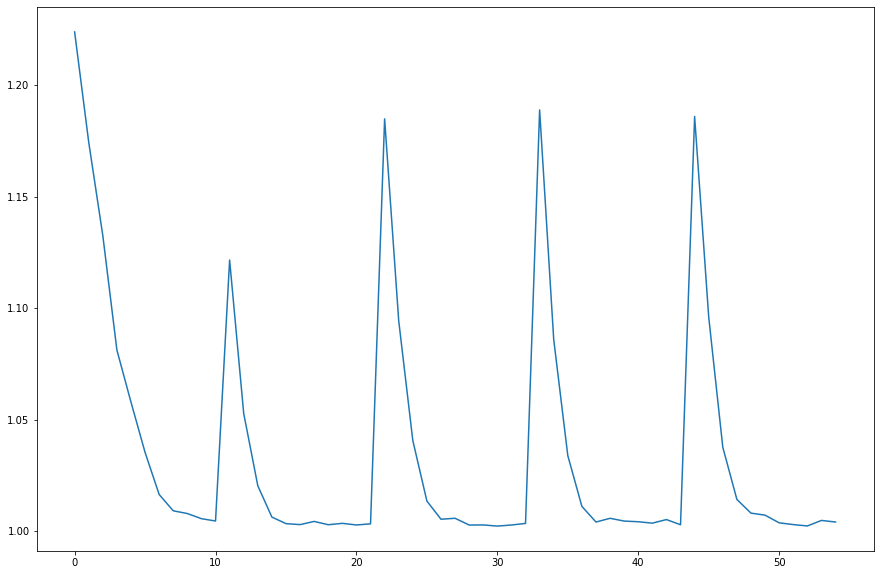

In [58]:
plt.plot(np.arange(len(fitness_means)), fitness_means)